### Simulating the dynamics of a levitated nanoparticle

This notebook will show how to simulate a levitated nanoparticle under the action of a cubic force with delay. To do this we are going to:

* Define an environment where the dynamics of a levitated nanoparticle is considered;
* Generate traces via Euler-Maruyama simulation;
* Making the plots showed in the *Results* section of the paper.

A brief summary of the organization of this notebook:

### Summary

- [1 - Packages and imports](#1)

- [2 - Creating the virtual nano-particle](#2)

- [3 - Generating traces](#3)

- [4 - Plots and comparison with theoretical predictions](#4)

<a name='1'></a> 
### 1. Packages and imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from non_linearity.environment import Particle
from non_linearity.simulation import simulation
import non_linearity.utils.constants as ct
from scipy import signal as sn

In [2]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

<a name='2'></a> 
### 2. Creating the virtual nano-particle

Here we are going to define some parameters for simulations. First, the particle frequency $f$, from this, we know the period $T$ and the angular frequency $\omega$. The period is going to be used to define the maximum simulation time $t_{max}$. The parameter $M$ represents the number of traces that are going to be created, we will simulate two different gains $G_1=6\times 10^5 \,\textrm{N/m}^3$ and $G_2=2\times 10^5 \,\textrm{N/m}^3$. For this simulation the $\gamma$ used was $66\times 10^3 \textrm{s}^{-1}$.

In [3]:
freq = 81.5e3
omega = 2*np.pi*freq
T = 1 / freq
max_time = 500 * T
M = 500
delta_t = 2e-7
N_time = int(max_time / delta_t)
t = np.linspace(0, max_time, int(N_time))
gamma = 66e3
gain1 = 2e5
gain2 = 6e5

In [4]:
env = Particle(omega, gamma, radius=73e-9)

<a name='3'></a> 
### 3. Generating traces

To create the traces we will call a function from our package, the `simulation` will run the Euler-Maruyama algorithm using Numba, this will allow for an optimized run, reducing time consumption. We also defined a `psd` function to run the `welch` method from `scipy.signal` on dictionary of traces.

In [5]:
def psd(traces, delta_t):
    pxxs = []
    for i in range(traces.shape[0]):
        freq, pxx = sn.welch(traces[i,:], fs=1/delta_t, window='hamming', nperseg=int(traces.shape[1]/2))
        if not np.isnan(pxx.max()) and not pxx.max() > 1e12:
            pxxs.append(pxx)
    return freq, np.array(pxxs)


def generate_traces(env, gain, delta_t, N_time,  M, delay_range):
    cubic_delayed = {i: [None] for i in delay_range}
    print("-- Creating traces --")
    for key in tqdm(cubic_delayed.keys()):
        cubic = np.zeros(shape=(M, N_time))
        for i in range(M):
            data = simulation(env.__omega__, env.__gamma__, env.thermal_force_std, delta_t, N_time, gain*(env.zp_x**3/env.zp_p), key)
            data = np.array(data)
            cubic[i, :] = data
        cubic_delayed[key] = cubic
    print("-- Analysing and making PSD --")
    delay_areas,  areas_std = [], []
    for key in tqdm(list(cubic_delayed.keys())):
        freq, pxx = psd(cubic_delayed[key], delta_t)
        delay_areas.append(pxx.sum(axis=1).mean())
        areas_std.append(pxx.sum(axis=1).std())

    return delay_areas, areas_std, freq

In [6]:
delay_range = range(0,62,1)
areas_gain1, _, _ = generate_traces(env, gain1, delta_t, N_time, M, delay_range)

-- Creating traces --


  0%|          | 0/62 [00:00<?, ?it/s]

100%|██████████| 62/62 [01:10<00:00,  1.13s/it]


-- Analysing and making PSD --


100%|██████████| 62/62 [02:21<00:00,  2.28s/it]


In [7]:
areas_gain2, _, _ = generate_traces(env, gain2, delta_t, N_time, M, delay_range)

-- Creating traces --


100%|██████████| 62/62 [01:03<00:00,  1.02s/it]


-- Analysing and making PSD --


100%|██████████| 62/62 [02:38<00:00,  2.56s/it]


In [8]:
areas_ref, areas_std_ref, freq = generate_traces(env, 0, delta_t, N_time, M, [0])

-- Creating traces --


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


-- Analysing and making PSD --


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


<a name='4'></a> 
### 4. Plots and comparison with theoretical predictions

Here we will define the autocorrelation functions, both zero and first order corrections. This will be used to compared the theory with simulation, which will be done in the last cell, via the plots that will be saved under the name `area_ratio_vs_delay.png`.


In [9]:
def autocor_0(t, omega, gamma, m= 3.368e-18, T = 293):
    C = 2*(gamma*ct.kb*T/m)
    Omega = np.sqrt(omega**2-((gamma**2)/4))
    T0 = C*np.exp(-gamma*t/2)*(2*Omega*np.cos(Omega*t)+gamma*np.sin(Omega*t))/(4*gamma*Omega*(omega**2))
    return T0


def autocor_perturbation(t, omega, gamma, b, tau, m= 3.368e-18, T = 293):
    T0 = autocor_0(t, omega, gamma, m=m)
    C = 2*(gamma*ct.kb*T/m) 
    Omega = np.sqrt(omega**2-((gamma**2)/4))
    mult = np.exp(-gamma*t/2)/(64*(gamma**3)*(Omega**4)*(omega**6))
    part1 = np.exp(gamma*tau/2)*(8*gamma*(Omega**4)-4*(omega**2)*(gamma**2)*(Omega**2)*(t-tau))*np.cos(Omega*(t-tau))
    
    part2 = Omega*np.exp(gamma*tau/2)*(8*gamma*(Omega**2)*(omega**2)*(t-tau)+\
                                       8*(Omega**4)+4*(gamma**2)*(omega**2)+6*(gamma**2)*(Omega**2))*np.sin(Omega*(t-tau))
    part3 = np.exp(-gamma*tau/2)*(Omega**2)*(2*Omega*(gamma**2)-8*(Omega**3))*np.sin(Omega*(t+tau))
    part4 = np.exp(-gamma*tau/2)*8*gamma*(Omega**4)*np.cos(Omega*(t+tau))
    T1 = -3*C*C*b*mult*(part1+part2+part3+part4)
    return T0+T1

In [10]:
theory_delays = np.linspace(0, T, 100)
areas_1 = autocor_perturbation(0, env.__omega__, env.__gamma__, -gain1/env._m_, theory_delays, m=env._m_)
areas_2 = autocor_perturbation(0, env.__omega__, env.__gamma__, -gain2/env._m_, theory_delays, m=env._m_)

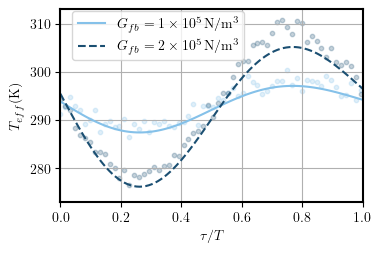

In [11]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure(figsize=(5.4*1.3*10, 10*4.2))
fig.set_size_inches(3*1.3, 2.5, forward=True)

plt.plot(theory_delays/T, 0.5*(ct.hbar*2*np.pi/(ct.kb*T))*(areas_1/(env.zp_x**2)-1/2), color=colors[1], label=r"$G_{fb}=1\times 10^5\,\textrm{N/m}{}^3$")
plt.scatter(delta_t*np.array(delay_range)/T, 0.5*(ct.hbar*2*np.pi/(ct.kb*T))*(np.array(areas_gain1)*np.diff(freq)[0]-1/2),s=10, color=colors[1], alpha=0.25, label=r"_$G_{fb}=1\times 10^5\,\textrm{N/m}{}^3$")


plt.plot(theory_delays/T, 0.5*(ct.hbar*2*np.pi/(ct.kb*T))*(areas_2/(env.zp_x**2)-1/2), color=colors[2], label=r"$G_{fb}=2\times 10^5\,\textrm{N/m}{}^3$", linestyle='dashed')
plt.scatter(delta_t*np.array(delay_range)/T, 0.5*(ct.hbar*2*np.pi/(ct.kb*T))*np.array(areas_gain2)*np.diff(freq)[0]-1/2,s=10, color=colors[2], alpha=0.25, label=r"_$G_{fb}=5.9\times 10^5\,\textrm{N/m}{}^3$")

plt.xlabel(r'$\tau/T$')
plt.ylabel(r'$T_{eff} (\textrm{K})$')
#plt.plot([5e-7/T, 5e-7/T], [0, 315], linestyle='dotted', color='black')
plt.ylim([273, 313])
plt.xlim([0, 1])
plt.legend(bbox_to_anchor=(0.016, 0.7, 1., .102))
plt.grid()
plt.savefig('../plots/area_ratio_vs_delay.pdf',dpi=300, bbox_inches = 'tight')